In [371]:
import numpy as np
import matplotlib 
import matplotlib as mpl
import fitsio
import os, glob
from astropy.table import Table, join, unique, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.gaia import Gaia

%pylab inline --no-import-all

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


In [372]:
ls ../data

Majaess_170_short.dat
SingleSource[FILE=wrs_gaia.csv].csv
SingleSource[FILE=wrs_gaia.csv].vot
SingleSource[FILE=wrs_gaia_201-400.csv].csv
SingleSource[FILE=wrs_gaia_401-600.csv].csv
SingleSource[FILE=wrs_gaia_601-657.csv].csv
SingleSource[FILE=wrs_gaia_601-657.csv].vot
majaess_170.csv
majaess_170.vot
majaess_crossmatch.numbers
wr_dists.vot
wrs.csv
wrs_all_match.csv
wrs_all_match.vot
wrs_dists.csv
wrs_gaia.csv
wrs_gaia_201-400.csv
wrs_gaia_401-600.csv
wrs_gaia_601-657.csv


In [373]:
tab = Table.read('../data/wrs_all_match.csv')

In [376]:
tab.write('../data/wrs_all_match.vot',format='votable',overwrite=True)

In [377]:
dists = Table.read('../data/wrs_dists.csv')

In [378]:
catalog = Table.read('../data/wrs.csv')

In [379]:
good_dists = unique(dists,keys='source_id')
all_gaia = join(tab,good_dists,join_type='outer',keys='source_id')

In [380]:
wrs = hstack([catalog,all_gaia])

In [381]:
def abs_mag(app_mag,dist):
    return app_mag - 5.*(np.log10(dist) - 1.)

In [382]:
for band in ['bp','g','rp']:
    wrs['abs_%s' % band.capitalize()] = abs_mag(wrs['phot_%s_mean_mag' % band],wrs['r_est'])
    wrs['abs_%s_hi' % band.capitalize()] = abs_mag(wrs['phot_%s_mean_mag' % band],wrs['r_hi'])
    wrs['abs_%s_lo' % band.capitalize()] = abs_mag(wrs['phot_%s_mean_mag' % band],wrs['r_lo'])

for band in ['J','H','K']:
    wrs['abs_%s' % band] = abs_mag(wrs[band],wrs['r_est'])
    wrs['abs_%s_hi' % band] = abs_mag(wrs[band],wrs['r_hi'])
    wrs['abs_%s_lo' % band] = abs_mag(wrs[band],wrs['r_lo'])

/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [383]:
wrs.write('wr_gaia_catalog.csv')

### Let's look at what the WR catalog has for us!

First, let's look in the visible.

In [384]:
errorbars = np.zeros((2,np.size(wrs['abs_G'])))
errorbars[0,:] = wrs['abs_G_hi']-wrs['abs_G']
errorbars[1,:] = wrs['abs_G']-wrs['abs_G_lo']

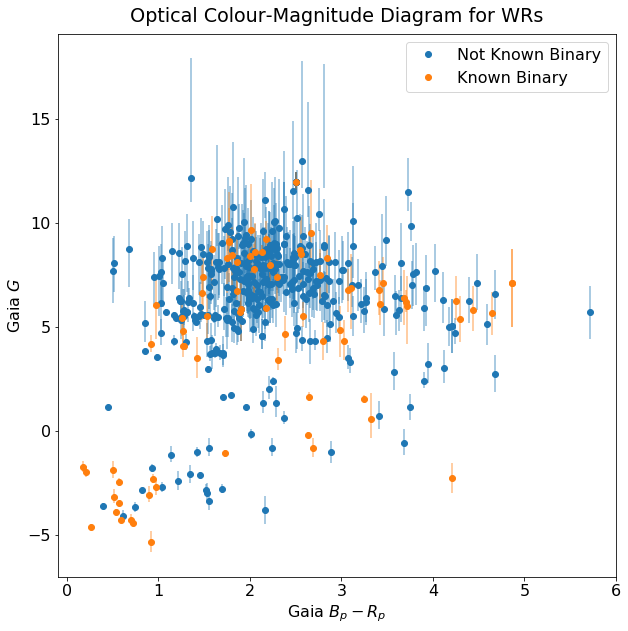

In [385]:
plt.plot(wrs['bp_rp'][~binary],wrs['abs_G'][~binary],'.',markersize=12,label='Not Known Binary')
plt.errorbar(wrs['bp_rp'][~binary],wrs['abs_G'][~binary],yerr=errorbars[:,~binary],fmt=None,alpha=0.5,color=colours[0])

plt.plot(wrs['bp_rp'][binary],wrs['abs_G'][binary],'.',markersize=12,label='Known Binary')
plt.errorbar(wrs['bp_rp'][binary],wrs['abs_G'][binary],yerr=errorbars[:,binary],fmt=None,alpha=0.5,color=colours[1])
plt.legend(['Not Known Binary','Known Binary'])

plt.xlabel(r'Gaia $B_p-R_p$')
plt.ylabel(r'Gaia $G$')
plt.title('Optical Colour-Magnitude Diagram for WRs',y=1.01)
plt.savefig('gaia_wr_cmd.png')

Now, let's look in the near infrared.

In [389]:
errorbars_J = np.zeros((2,np.size(wrs['abs_J'])))
errorbars_J[0,:] = wrs['abs_J_hi']-wrs['abs_J']
errorbars_J[1,:] = wrs['abs_J']-wrs['abs_J_lo']

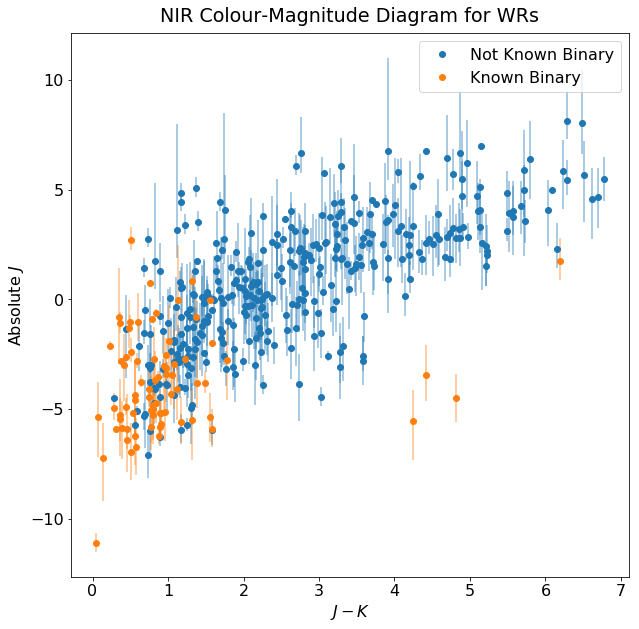

In [390]:
plt.plot((wrs['J']-wrs['K'])[~binary],wrs['abs_J'][~binary],'.',markersize=12,label='Not Known Binary')
plt.errorbar((wrs['J']-wrs['K'])[~binary],wrs['abs_J'][~binary],yerr=errorbars_J[:,~binary],fmt=None,alpha=0.5,color=colours[0])

plt.plot((wrs['J']-wrs['K'])[binary],wrs['abs_J'][binary],'.',markersize=12,label='Known Binary')
plt.errorbar((wrs['J']-wrs['K'])[binary],wrs['abs_J'][binary],yerr=errorbars_J[:,binary],fmt=None,alpha=0.5,color=colours[1])
plt.legend(['Not Known Binary','Known Binary'])

plt.xlabel(r'$J-K$')
plt.ylabel(r'Absolute $J$')
plt.title('NIR Colour-Magnitude Diagram for WRs',y=1.01)
plt.savefig('gaia_wr_nir_cmd.png')

### How bad is the astrometry?

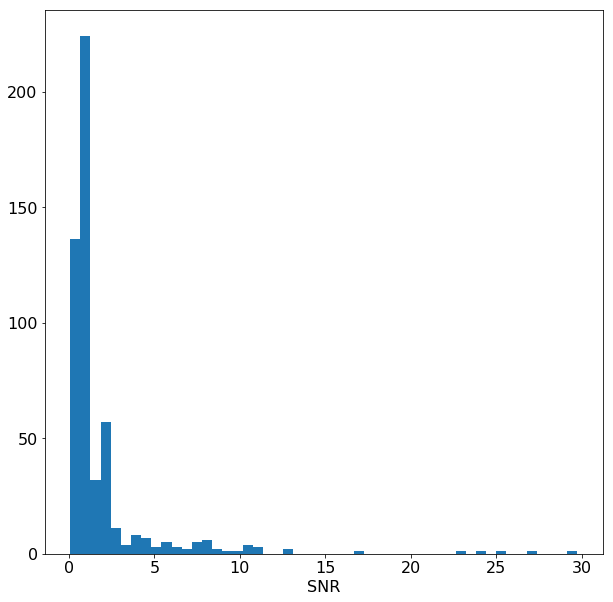

In [393]:
snrs = wrs['r_est']/(wrs['r_hi']-wrs['r_lo'])
h = plt.hist(snrs,bins=50)
plt.xlabel('SNR');

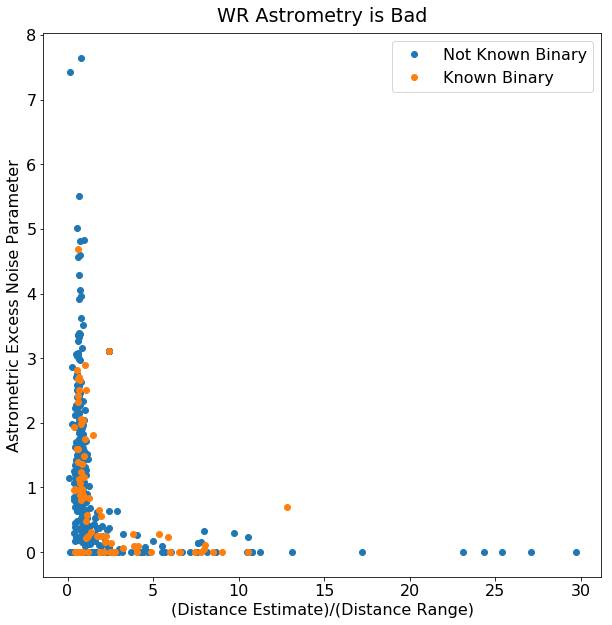

In [391]:
plt.plot(snrs[~binary],wrs['astrometric_excess_noise'][~binary],'.',markersize=12,label='Not Known Binary')
plt.plot(snrs[binary],wrs['astrometric_excess_noise'][binary],'.',markersize=12,label='Known Binary')

plt.xlabel('(Distance Estimate)/(Distance Range)')
plt.ylabel('Astrometric Excess Noise Parameter')
plt.title('WR Astrometry is Bad',y=1.01)
plt.legend()
plt.savefig('bad_astrometry.png')

### Which WRs have good SNR?

In [394]:
m = ~np.ma.getmask(snrs)*(snrs>10)
m.sum()

15

In [395]:
wrs[m]['WR#']

7a
20b
24
31c
47
47-1
47-2
70a
76-11
81
84-4
